# NLP DEAP Project

# 0. Objectives

### PoC 2: Identify key AI subjects most relevant to professional sectors 

- AI breakthroughs are appearing in almost all the professional sectors existing today, even the most unexpected ones (Art, entertainment, animation). Given these uncommon associations, it may be interesting for universities to provide at least high level knowledge of these new subjects to their students to facilitate future integration and projects in their domain of expertise. Although the scope of AI is very vast, it can range from advanced statistics to graph theory, deep learning, computer vision, and many more. It's unfeasible to even introduce all the subjects that fall in that scope, even on a high level. This was what let to this project, finding for each sector which topic in AI may be most interesting to mention for law students, art students and others. 
- In order to do so, we've decided to consider that recent publications, journals and research articles constitue a mirror or at least a representation of AI breakthroughs in professional sectors. By using these journals and the material they cover we attempt to discover which topics in AI are most recurrent across publications for a given sector. By retrieving the titles and abstracts of recent articles on one side, and retrieving AI topic descriptions on the other we can identify to which AI topic the bulk of publications within a sector are the closest to. 
- In order to garranty the feasibility of this project we had to limit the scope of our scraping. First of all, we've agreed to select 10 NACE sectors as a basis for this PoC. Second, for each sector we search articles only among the top 10 most relevant journals for that sector according to Scimago. Third, we only look at publications from 2015 onward to catch the "Big Data" wave. Integrating these constraints, we proceed to do advanced Google Scholar searches using the sector name associated with at least one of approximately 100 AI key topics ranging from vast (Machine learning, Big Data, Statistics) to narrower definitions (Deep Learning, Recursive Neural Networks, K-Means clustering). 
- On one side, for each sector we scrape approximately 100 article titles and short abstracts to use as our representation of AI breakthroughs in each sector. On the other, we've scraped 11 AI education programs from 10 different european countries retrieving courses and course content in a similar fashion as the scraping that was done in PoC 1. We then have our texts of each side, "Sector AI Breakthrough" strings and "AI Topic description" strings for which we seek to compute the similarity in meaning/context as we did in PoC 1.  
- To find this proximity, we proceed in the same manner as PoC 1. We pre-process, vectorize and compute cosine similarity of vector representations from our two lists of strings using Google's pre-trained Word2Vec model. Again we only consider sets of strings that seem most relevant to each other by considering a threshold of 0.78. Then, for each sector we take only the top 5 AI topics in terms of score to avoid recommending too many topics in AI and falling beside the point of this PoC. 
- Once these links are established, we effectively can identify the most relevant AI topics per sector. Since we are again interested in links between elements the graph approach seemed the best suited to this PoC as well. You will find the construction of the interactive graph in the R scripts provided alongside this notebook. 

    This notebook contains only the pre-processing, vectorization, cosine similarity computations and recording in new dataframes of our NACE sector and AI breakthrough datasets.

# 1. The code

## 1.1 Loading packages and data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk, string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import corpora
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

import spacy

import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

from gensim.similarities import docsim
#from DocSim import DocSim

C:\Users\laksa\Documents\anaconda_3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\laksa\Documents\anaconda_3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


We drop any rows that do not contain course description

the function below reads whatever csv data you specify the path for and automatically does some pre-processing and wrangling steps on the text column(s) you want to match. Typically if you want to combine several columns containing text for matching afterwards, just specify the names of those columns in addition to the main one in "other_columns" input. 

In [ ]:
def read_clean_data(path,column_name,other_columns = None):
    
    data = pd.read_csv(str(path), encoding = "ISO-8859-1")

    
    if other_columns:
        data['Extended'] = data[str(column_name)]
        for col in other_columns:
            data['Extended'] = data['Extended'] + data[str(col)].map(str)
    
    # Reads the data in the path you specified, drops na's and resets the index to avoid concatenation failures afterwards
    data.dropna(subset=[column_name],inplace = True)
    data.reset_index(drop = True, inplace = True)
    
    # Takes care of decoding all characters to avoid miss-steps in the datacleaning process!
    for i in range(0,len(data)):
        if other_columns:
            temp1 = data.loc[i,'Extended']
            temp2 = unidecode.unidecode(str(temp1))
            data.loc[i,"Clean_strings"] = temp2
        else:
            temp1 = data.loc[i,str(column_name)]
            temp2 = unidecode.unidecode(str(temp1))
            data.loc[i,"Clean_strings"] = temp2
        
    return data
latvia = read_clean_data(path = "Data/AI programs.csv",
                        column_name = 'Syllabus')
skills = read_clean_data(path = 'Data/google_scholar_articles_full.csv',
                        column_name = 'AI_topics',
                        other_columns = ['Titles','Abstracts'])

##### Or you can fetch the data manually as below. (I prefer my function above :P)

In [38]:
ai_courses_list = aip['Syllabus'].tolist()
ai_courses_list[:5]

['This seminar tries to inform and guide the students about techniques, most common standards and systems for the practice of scientific research and its methodological bases and documentaries. The topics are as follows: General Approach (scientific knowledge and its purpose, problems of scientific research, research works); Scientific Work (choice of subject, setting objectives, formulating hypotheses, choice of work method, choice of tools and resources. Phases of work); Information Search (sources, publications, bibliographical searches, access to scientific documentation, internet, etc.); Work Writing (rules, principles, tips, style, language, etc.) and Presentation and Defence of Work (legal aspects, formal aspects, personal aspects, visual aids to support the presentation)',
 'This seminar will cover fundamental aspects of project management and risk\r\ncontrol. It will be possible for the student to understand the principles of project\r\nmanagement, risk and change management, 

We load the articles scraped from google scholar, combine the abstracts and titles into one column and drop any rows that are empty for that column (no title and no abstract)

In [136]:
data = pd.read_csv('Data/google_scholar_articles_full.csv', encoding = 'ISO-8859-1')
    
data['Titles'] = data['Titles'].astype(str)
data['Abstracts'] = data['Abstracts'].astype(str)
data['Sector'] = data['Sector']

data.head()
data.shape

for i in range(0,len(data)):
    data.loc[i,'AI_topics'] = data.loc[i,'Titles'] + data.loc[i,'Abstracts']
data.head()

,Titles,Abstracts,Sector,AI_topics
0,[PDF][PDF] The Impact of Technology on Contemp...,and calculators have been used to assist in ...,Legal and accounting activities,[PDF][PDF] The Impact of Technology on Contemp...
1,Business intelligence & analytics in managemen...,that although there is potential for studyi...,Legal and accounting activities,Business intelligence & analytics in managemen...
2,[PDF][PDF] Is India Digitally Prepared for Int...,Data intelligence manifests itself in design...,Legal and accounting activities,[PDF][PDF] Is India Digitally Prepared for Int...
3,[PDF][PDF] Bankruptcy risk prediction models b...,"As part of the Artificial Intelligence, the ...",Legal and accounting activities,[PDF][PDF] Bankruptcy risk prediction models b...
4,Influence of Artificial Intelligence on Activi...,"view and edit this information), but also ab...",Legal and accounting activities,Influence of Artificial Intelligence on Activi...


## 1.2 Pre-processing

Again we use four pre-processing steps as in PoC 1:
    - Stopwords (remove unmeaningful words)
    - Punctuations (remove special characters to avoid confusions)
    - Lowercase (get rid of uppercase to avoid missing similar words)
    - Lemmatization (Keep only the lemma of each word to reduce distance between words which are the same but have a conjugation or are constructed differently given the sentence in which it is used)

In [2]:
stopW = stopwords.words('english')
stopW += ["msc","also","pdf",'book']
special_characters = [",","?",".",";","/",":","+","=","~","%","´",
                      "`","¨","^","*","$",'&',"|","@",'"',"£",
                      "'","(",")","§","!","{","}","-","_","²","[",
                      ">","<","]"]

transformation_sc_dict = {initial :" " for initial in special_characters}
lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Deleting words with only one character
    tokens = [token for token in tokens if len(token)>2]
    
    # Stopwords + Lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]
    
    # Deleting specific characters
    tokens = [token.translate(str.maketrans(transformation_sc_dict)) for token in tokens]
    
    # Lemmatization (optional)
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos = 'a'),pos = 'v'),pos='n') for token in tokens]
    
    return tokens

# Just to try it out, apply the pre processing function to the program descriptions.
data['tokens'] = data["AI_topics"].apply(preprocessing)

NameError: name 'stopwords' is not defined

#### Visaulization tool to reverse engineer pre-processing:

As in PoC 1, this section is mainly to reverse engineer the pre-processing we want to apply to our strings

In [67]:
def plot_frequent_words(list_of_words):
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(40)]
    y = [nb[0] for nb in dist.most_common(40)]
    ax = sns.barplot(X,y)
    ax.set(xlabel = 'Word Frequencies', ylabel = 'Words', title = 'Most common words in the corpus')
    plt.show()

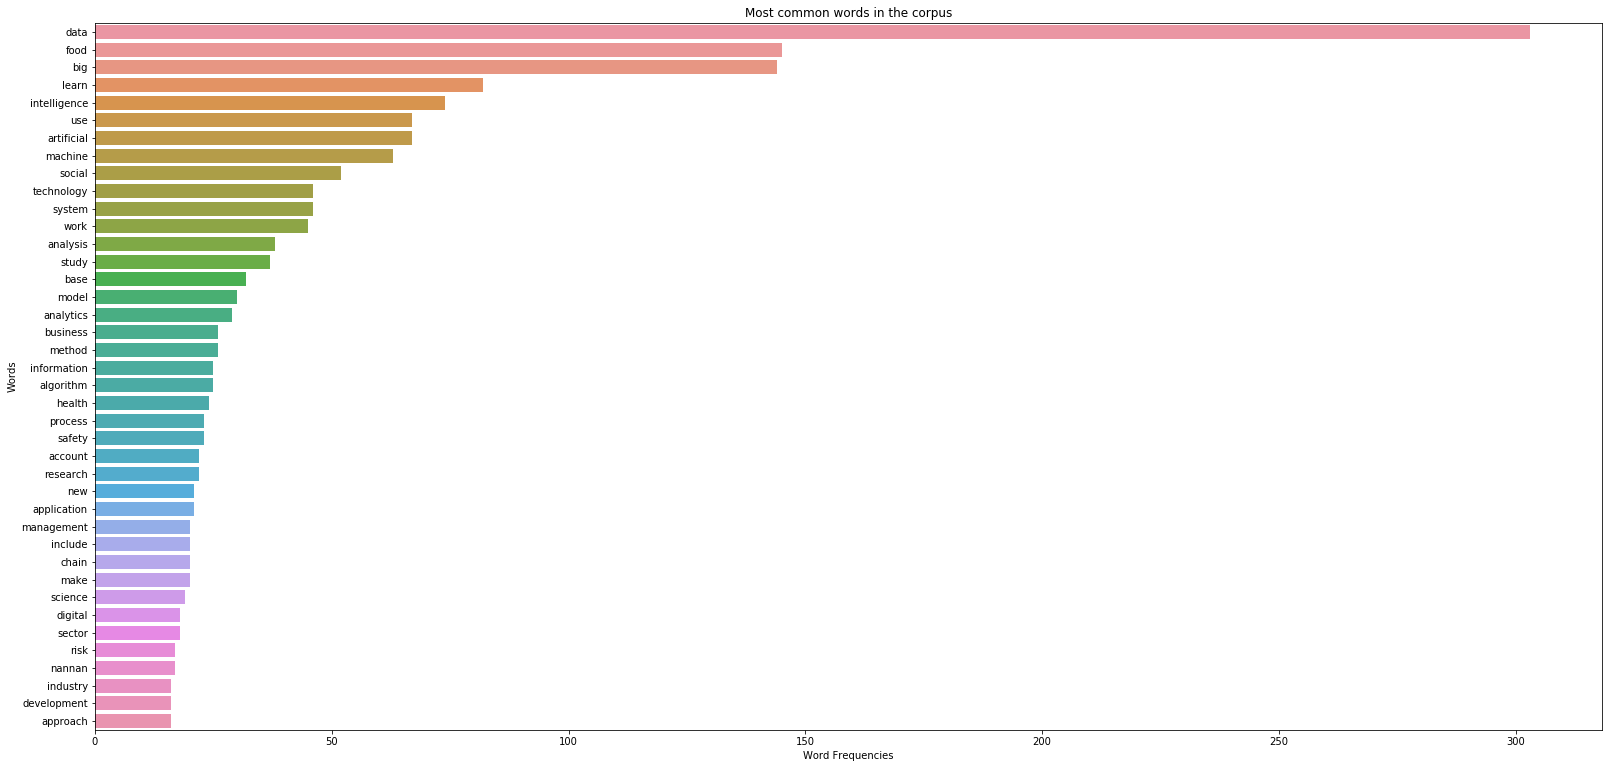

6258


In [68]:
plt.figure(figsize=(27,13))

ep_words = data.tokens.tolist()
ep_words2 = [[text.strip() for text in descr] for descr in ep_words]
clean_words_ep = [[word for word in words if word != ''] for words in ep_words2]
data['clean_tokens'] = clean_words_ep

ep_full_words = []
for descr in clean_words_ep:
    for word in descr:
        ep_full_words.append(word)
        
plot_frequent_words(ep_full_words)
print(len(ep_full_words))

# 1.3 V.1.0 (better matching algorithm in section 1.4!!) Linking sector-specific AI breakthroughs to AI topics

#### loading google word embeddings

Like in PoC 1, we use Google's pre-trained word2vec model to vectorize our strings 

In [30]:
wv_from_bin = KeyedVectors.load_word2vec_format(r'C:\Users\laksa\Documents\DEAP\NLP AI\GoogleNews-vectors-negative300.bin', binary = True)

We use the same algorithm as in PoC 1, which applies the pre-processing we've optimized for our data above, vectorizes the resulting string using the model's word embeddings and computes the cosine similarity of any two vectors it is fed, recording only the matches that score higher than a chosen threshold

In [42]:
ds = DocSim(wv_from_bin)
punctuation_map = dict((ord(char), None) for char in string.punctuation)
class DocSim(object):
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map

    def vectorize(self, doc):
        """Identify the vector values for each word in the given document"""
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in self.stopwords]
        word_vecs = []
        for word in words:
            try:
                vec = self.w2v_model[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim

    def calculate_similarity(self, source_doc, target_docs=[], threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        if isinstance(target_docs, str):
            target_docs = [target_docs]

        source_vec = self.vectorize(source_doc)
        results = []
        for doc in target_docs:
            target_vec = self.vectorize(doc)
            sim_score = self._cosine_sim(source_vec, target_vec)
            if sim_score > threshold:
                results.append({
                    'score' : sim_score,
                    'doc' : doc
                })
            # Sort results by score in desc order
            results.sort(key=lambda k : k['score'] , reverse=True)

        return results

#### Applying the algo to our data

Again, like in PoC 1 we initialize a void list which will contain all the matches between articles and ai topic descriptions scoring higher than 0.78

In [138]:
sector_ai_courses = []
import time

start = time.time()
for i in range(0,len(data)):
    sector_ai_courses.append(ds.calculate_similarity(data['AI_topics'][i],ai_courses_list,threshold = 0.78))
end = time.time()
print(end-start)

318.7181043624878


### Creating a dataframe for our results 

As we are unsure if an article is actually representative or not of an AI breakthrough, we add an additionnal limit before generating a new dataframe with the matches established above. If an articles has at least 5 matches with different AI topic descriptions, this article will be taken into account to establish the link between a sector and AI topics. If an article passes this limit, we then take only the top 5 highest scoring AI topics for that article.

In [139]:
test = pd.DataFrame(columns=['Sector','Courses','Score','Syllabus','AI_topics'])
l = 0
for j in range(0,len(sector_ai_courses)):
    if len(sector_ai_courses[j]) >= 5:
        for i in range(0,5):
            temp1 = aip[aip['Syllabus'] == (sector_ai_courses[j][i]['doc'])].Courses.item()
            temp2 = sector_ai_courses[j][i]['doc']
            temp3 = sector_ai_courses[j][i]['score']

            test.loc[l,['Sector','AI_topics']] =  data.loc[j,['Sector','AI_topics']]
            test.loc[l,['Courses']] = temp1
            test.loc[l,['Syllabus']] = temp2
            test.loc[l,['Score']] = temp3
            l += 1
    else:
        pass

The result is as showed below. Now that the link has been established between every article of each selected sector and the 300 AI topics we've scraped we thus have a proxy for the most relevant AI topics per sector given the AI breakthroughs within.

In [132]:
test.head()

,Sector,Courses,Score,Syllabus,AI_topics
0,Legal and accounting activities,Data Analystics for Smart Grids,0.829418,To provide students with the ability to design...,Business intelligence & analytics in managemen...
1,Legal and accounting activities,Biomedical Informatics,0.818984,Biomedical informatics tries to analyse proble...,Business intelligence & analytics in managemen...
2,Legal and accounting activities,Machine Learning,0.818038,In Machine Learning we develop algorithms that...,Business intelligence & analytics in managemen...
3,Legal and accounting activities,Artificial Intelligence and Data Science,0.814577,At the core of Data Science are methods for an...,Business intelligence & analytics in managemen...
4,Legal and accounting activities,Information Retrieval,0.81244,"The way we access, provide, and exchange infor...",Business intelligence & analytics in managemen...


We then simply write the data to csv

In [140]:
test.to_csv('ai_courses_all_sectors_2.csv')

# 1.4 V.2.0 Linking sector-specific AI breakthroughs to AI topics - made easy

In [ ]:
punctuation_map = dict((ord(char), None) for char in string.punctuation)
class DocSimV2(object):
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map

    def vectorizer(self, doc):
        """Identify the vector values for each word in the given document"""
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in stopW]
        word_vecs = []
        for word in words:
            try:
                vec = wv_from_bin[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim
        
    def calculate_similarity(self, datasetA, text_datasetA, datasetB, text_datasetB, threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        datasetA.reset_index(inplace = True,drop = True)
        datasetB.reset_index(inplace = True,drop = True)
        datasetA["vectors"] = datasetA[str(text_datasetA)].apply(self.vectorizer)
        datasetB["vectors"] = datasetB[str(text_datasetB)].apply(self.vectorizer)
        
        
        #colsA = list(datasetA.columns.values)
        #colsB = list(datasetB.columns.values)
        #cols = [colsA,colsB]
        #flat_cols = [item for sublist in cols for item in sublist]
        #flat_cols.append("similarity")
        #result = pd.DataFrame(columns = flat_cols)
        #l = 0
        ind_A = []
        ind_B = []

        for i in range(0,len(datasetA)):
            vecA = datasetA.loc[i,"vectors"]
            for j in range(0,len(datasetB)):
                vecB = datasetB.loc[j,"vectors"]
                sim_score = self._cosine_sim(vecA,vecB)
                
                if sim_score > threshold:
                    ind_A.append(i)
                    ind_B.append(j)
                    
        matchesA = datasetA.loc[ind_A,:].drop(datasetA.columns[[0,1]],axis = 1)
        #matchesA = matchesA.set_index(pd.Index(range(0,len(matchesA))))#.drop(['level_0','index'], axis=1, inplace=True)#.reset_index(inplace = True, drop = True)
        matchesB = datasetB.loc[ind_B,:].drop(datasetB.columns[[0,1]],axis = 1)#.reset_index(inplace = True, drop = True)
        full_data = pd.concat([matchesA.reset_index(drop = True),matchesB.reset_index(drop = True)], axis=1)            
                    #result.loc[l,"similarity"] = sim_score
                    #result.loc[l,colsA] = datasetA.loc[i,colsB]
                    #result.loc[l,colsB] = datasetB.loc[j,colsB]
                    #l += 1
                     
                    
        return full_data
    
start = time.time()
ds = DocSimV2(wv_from_bin)
results = ds.calculate_similarity(datasetA = latvia,
                                  text_datasetA = "Clean_strings",
                                  datasetB = skills,
                                  text_datasetB = "Clean_strings",
                                  threshold = 0.78)
end = time.time()
print(end-start)

# 1.5 NLP automatic matching v.3.0.0 

Below is the last version of our string matching program which provides a complete walkthrough. The onyl input needed from the user is the directory to the data he wishes to match and a trained word2vec model.

In [ ]:
# Load Word2Vec model:
#wv_from_bin = KeyedVectors.load_word2vec_format(r'C:\Users\laksa\Documents\DEAP\NLP AI\GoogleNews-vectors-negative300.bin', binary = True)

lemmatizer = WordNetLemmatizer()    
    
#Pre-processing:
punctuation_map = dict((ord(char), None) for char in string.punctuation)
#stop_words = set(stopwords.words("english"))
#stopW = []
#for element in stop_words:
#    stopW.append(element)
stopW = stopwords.words('english')
stopW += ["msc","also",'teaching','class','student',"classroom","teach",'learn']
special_characters = [",","?",".",";","/",":","+","=","~","%","´",
                      "`","¨","^","*","$",'&',"|","@",'"',"£",
                      "'","(",")","§","!","{","}","-","_","²","[",
                      ">","<","]"]

class DocSimV3(object):
    
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map
    
    def read_clean_data(self,path_A,path_B):
        """Cleaning, wrangling automated on the two datasets you consider for matching"""

        for path in [path_A,path_B]:
            
            if path == path_A:
                print("These are the columns of the first dataset you want to match:")
            else:
                print("These are the columns of the second dataset you want to match:")
            print("\n")
            
            data = pd.read_csv(str(path), encoding = "ISO-8859-1")
            data.reset_index(drop = True, inplace = True)
            
            #######################
            #for testing purposes:
            data = data.sample(3) 
            #######################
            
            print('\n')
            for name in data.columns:
                print(name)
            print('\n')
                
            column_name = []
            other_columns = []
                
            colA = input("What's the name of the column that contains the strings you'd like to use for matching?")
            while colA not in list(data.columns):
                print("This columns doesn't exist in your data, try another one from the list printed above!")
                print('\n')
                colA = input("What's the name of the column that contains the strings you'd like to use for matching?")

            column_name.append(str(colA))
                
            while colA != "stop":
                colA = input('Are there other columns that should be used for the matching? If not type "stop"!')
                print('\n')
            
                if colA != 'stop' and colA in list(data.columns):
                    other_columns.append(str(colA))
                    print("You've already selected the following:")
                    print('\n')
                    print(column_name[0])
                    for name in other_columns:
                        print(name)
                    print('\n')
            
                elif colA == 'stop':
                    print('Moving on!')
                    print('\n')
                    break

                elif colA not in list(data.columns):
                    print("This columns doesn't exist in your data, try another one from the list printed above!")
                    print('\n')
                    continue
                    
            if other_columns != []:
                data['Extended'] = data[column_name[0]]
                for col in other_columns:
                    data['Extended'] = data['Extended'] + data[str(col)].map(str)
    
    # Reads the data in the path you specified, drops na's and resets the index to avoid concatenation failures afterwards
            data.dropna(subset=column_name,inplace = True)
            data.reset_index(drop = True, inplace = True)
            print("\n")
            print("Please wait while we process your data!")
            print("\n")
    
    # Takes care of decoding all characters to avoid miss-steps in the datacleaning process!
            for i in range(0,len(data)):
                if other_columns:
                    temp1 = data.loc[i,'Extended']
                    temp2 = unidecode.unidecode(str(temp1))
                    data.loc[i,"Clean_strings"] = temp2
                else:
                    temp1 = data.loc[i,column_name[0]]
                    temp2 = unidecode.unidecode(str(temp1))
                    data.loc[i,"Clean_strings"] = temp2
            
            if path == path_A:
                dfA = data
            else:
                dfB = data
            
        return dfA,dfB
                        
    def vectorizer(self, doc):
        """Identify the vector values for each word in the given document"""
        #stopW = stopwords
        #doc = doc.lower()
        #doc = re.sub(r'[^\w\s]','',doc)
        #words_1 = [w for w in doc.split(" ")]
        #words_2 = [word for word in words_1 if word not in stopwords.words('english')]
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in stopW]
        words = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w, pos = 'a'),pos = 'v'),pos='n') for w in words]
    
        word_vecs = []
        for word in words:
            try:
                vec = wv_from_bin[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim
    
    def similarity_join(self,data):
    
        data.reset_index(inplace = True, drop = True)
        
        print("\n")
        print("The data model we considered for our graph rendering in the shiny app is as follows:","\n","\n",
             "University","\n",
             "Program","\n",
             "Course","\n",
             "Skill","\n","\n",
             "We highly recommend you select the columns in your dataset corresponding to those cited above if you want to visualize your matches in our Shinyapp.","\n",
             "Although this is entirely your decision, you may keep the ones you see as fittest.","\n",
             "If you do decide to follow our data model and wish to upload your data to our graph rendering, please specify which columns lin your data listed below correspond to the information listed above","\n")
        for name in data.columns:
            print(name)
        print('\n')
        
        cols = []
        col = input('Which columns would you like to keep?')
        print('\n')
    
        cols.append(col)
    
        while col != "stop":
            col = input('Any more columns you want to keep? If not type "stop"!')
            print('\n')
            
            if col != 'stop' and col in list(data.columns):
                cols.append(col)
            
            elif col == 'stop':
                print('You stopped the process')
                print('\n')
                data = data.loc[:,cols]
                return(data)

            elif col not in list(data.columns):
                print("This columns doesn't exist in your data, try another one from the list printed above!")
                print('\n')
                continue
                
    def graph_format(self, data):
        
        print("\n")
        start = input('Are you using our data model? If so type "Yes". If not, please type "Goodbye"')
        print("\n")
        if start == "Goodbye":
            print("K bye :'(")
            return data
        elif start == "Yes":
            print("\n","\n")
            print("University","\n",
                  "Program","\n",
                  "Course","\n",
                  "Skills")
            print("\n","\n","Please specify which columns in your data listed below correspond to those in our data model listed above.","\n","\n")
            for var in list(data.columns):
                print(var)

            univ=input("The column in your data that corresponds to 'University':")
            prog=input("The column in your data that corresponds to 'Program':")
            crse=input("The column in your data that corresponds to 'Course':")
            skil=input("The column in your data that corresponds to 'Skills':")
            print("\n","\n")
            
            data.rename(
                inplace = True,
                columns = 
                            {
                    str(univ):"University",
                    str(prog):"Program",
                    str(crse):"Course",
                    str(skil):"Skills"
                            }
                           )
                
            return data
        
    def calculate_similarity(self, path_A, path_B, threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        
        datasetA, datasetB = self.read_clean_data(path_A, path_B)
        print("\n")
        print("We cleaned your data!")
        print("\n")
        print("Please wait while we figure out the matches!")
        print("\n")
        
        #if datasetA["Clean_strings"] and datasetB["Clean_strings"]:
            
        datasetA.reset_index(inplace = True,drop = True)
        datasetB.reset_index(inplace = True,drop = True)
        datasetA["vectors"] = datasetA[str("Clean_strings")].apply(self.vectorizer)
        datasetB["vectors"] = datasetB[str("Clean_strings")].apply(self.vectorizer)
        
        #else:
        #    datasetA.reset_index(inplace = True,drop = True)
        #    datasetB.reset_index(inplace = True,drop = True)
        #    datasetA["vectors"] = datasetA[str(text_datasetA)].apply(self.vectorizer)
        #    datasetB["vectors"] = datasetB[str(text_datasetB)].apply(self.vectorizer)
        
        #colsA = list(datasetA.columns.values)
        #colsB = list(datasetB.columns.values)
        #cols = [colsA,colsB]
        #flat_cols = [item for sublist in cols for item in sublist]
        #flat_cols.append("similarity")
        #result = pd.DataFrame(columns = flat_cols)
        #l = 0
        ind_A = []
        ind_B = []
        score_record = []

        for i in range(0,len(datasetA)):
            vecA = datasetA.loc[i,"vectors"]
            for j in range(0,len(datasetB)):
                vecB = datasetB.loc[j,"vectors"]
                sim_score = self._cosine_sim(vecA,vecB)
                
                if sim_score > threshold:
                    ind_A.append(i)
                    ind_B.append(j)
                    score_record.append(sim_score)
                    
        matchesA = datasetA.loc[ind_A,:].drop(datasetA.columns[[0]],axis = 1)
        #matchesA = matchesA.set_index(pd.Index(range(0,len(matchesA))))#.drop(['level_0','index'], axis=1, inplace=True)#.reset_index(inplace = True, drop = True)
        matchesB = datasetB.loc[ind_B,:].drop(datasetB.columns[[0]],axis = 1)#.reset_index(inplace = True, drop = True)
        full_data = pd.concat([matchesA.reset_index(drop = True),matchesB.reset_index(drop = True)], axis=1)       
        full_data['Cosine_similarity'] = score_record
                    #result.loc[l,"similarity"] = sim_score
                    #result.loc[l,colsA] = datasetA.loc[i,colsB]
                    #result.loc[l,colsB] = datasetB.loc[j,colsB]
                    #l += 1
        print("\n","\n")
        print("We have your matches! Let's do some cleaning to tidy the results!")
        print("\n","\n")
        
        """Some additionnal cleaning for the end result"""
        intermediate = self.similarity_join(full_data)   
        
        """Recommended column names for easy grpah formatting afterwards"""
        final = self.graph_format(intermediate)            
        
        print("\n","\n")
        print("We're all set, go visualize that data!")
        print("\n","\n")
        
        return final